In [ ]:
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install scvi-tools

In [ ]:
!pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.6/597.6 kB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install infercnvpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 6.3 MB/s eta 0:00:00


In [ ]:
import csv
import gzip
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import gseapy
import infercnvpy as cnv
#import scvi
import matplotlib.pyplot as plt
import torch
from scipy.sparse import csr_matrix
import infercnvpy as cnv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# adata_file = '/content/drive/MyDrive/ALSF/SCPCP000023/SCPCP000023_merged_rna.h5ad'
adata_file = '/content/drive/MyDrive/ALSF/SCPCP000023/SCPCP000023_scvi_processed_rna.h5ad'
adata = adata = sc.read_h5ad(adata_file)

In [ ]:
adata

AnnData object with n_obs × n_vars = 195167 × 60319
    obs: 'barcodes', 'sum', 'detected', 'total', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'miQC_pass', 'prob_compromised', 'scpca_filter', 'additional_modalities', 'singler_celltype_annotation', 'singler_celltype_ontology', 'cellassign_celltype_annotation', 'cellassign_celltype_ontology', 'cellassign_max_prediction', 'consensus_celltype_annotation', 'consensus_celltype_ontology', 'library_id', 'cell_id', 'sample_id', 'scpca_project_id', 'submitter_id', 'participant_id', 'submitter', 'age', 'age_timing', 'sex', 'diagnosis', 'subdiagnosis', 'tissue_location', 'disease_timing', 'organism', 'is_xenograft', 'is_cell_line', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'tech_version', 'assay_ontology_term_id', 'suspension_type'
    var: 'gene_ids', 'gene_symbol', 'SCPCL001120.

# Step 1: Integrate and Batch Correct

In [ ]:
if not isinstance(adata.layers['spliced'], csr_matrix):
    adata.layers['spliced'] = adata.layers['spliced'].tocsr()
    print("Converted adata.layers['spliced'] to CSR format.")

In [ ]:
torch.set_float32_matmul_precision('medium')
print("Set torch matmul precision to 'medium'.")

In [ ]:
# Setup AnnData, specifying the batch key and the layer with raw counts
scvi.model.SCVI.setup_anndata(adata, layer='spliced', batch_key='sample_id')

In [ ]:
# Create and train the model

# Create the model
model = scvi.model.SCVI(adata)
# Set the number of parallel workers for data loading to fix the bottleneck warning.
num_workers = os.cpu_count()

# Train the model using the optimized settings
model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training:   0%|          | 0/41 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=41` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=41` reached.


In [ ]:
# prompt: save the scvi model to a model file

# Define the path to save the model
model_save_path = '/content/drive/MyDrive/ALSF/SCPCP000023/scvi_model'

# Save the model
model.save(model_save_path, overwrite=True)

print(f"SCVI model saved to: {model_save_path}")

SCVI model saved to: /content/drive/MyDrive/ALSF/SCPCP000023/scvi_model


In [ ]:
# Add the corrected latent representation to adata.obsm
adata.obsm['X_scVI'] = model.get_latent_representation()

In [ ]:
adata

AnnData object with n_obs × n_vars = 195167 × 60319
    obs: 'barcodes', 'sum', 'detected', 'total', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'miQC_pass', 'prob_compromised', 'scpca_filter', 'additional_modalities', 'singler_celltype_annotation', 'singler_celltype_ontology', 'cellassign_celltype_annotation', 'cellassign_celltype_ontology', 'cellassign_max_prediction', 'consensus_celltype_annotation', 'consensus_celltype_ontology', 'library_id', 'cell_id', 'sample_id', 'scpca_project_id', 'submitter_id', 'participant_id', 'submitter', 'age', 'age_timing', 'sex', 'diagnosis', 'subdiagnosis', 'tissue_location', 'disease_timing', 'organism', 'is_xenograft', 'is_cell_line', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'tech_version', 'assay_ontology_term_id', 'suspension_type', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids

In [ ]:
# Save the adata to a new h5ad file

output_adata_file = '/content/drive/MyDrive/ALSF/SCPCP000023/SCPCP000023_scvi_processed_rna.h5ad'
adata.write_h5ad(output_adata_file)
print(f"Processed adata saved to: {output_adata_file}")

Processed adata saved to: /content/drive/MyDrive/ALSF/SCPCP000023/SCPCP000023_scvi_processed_rna.h5ad


In [ ]:
# Compute neighbors and UMAP on the integrated data (Completes in ~5 mins)
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.umap(adata)

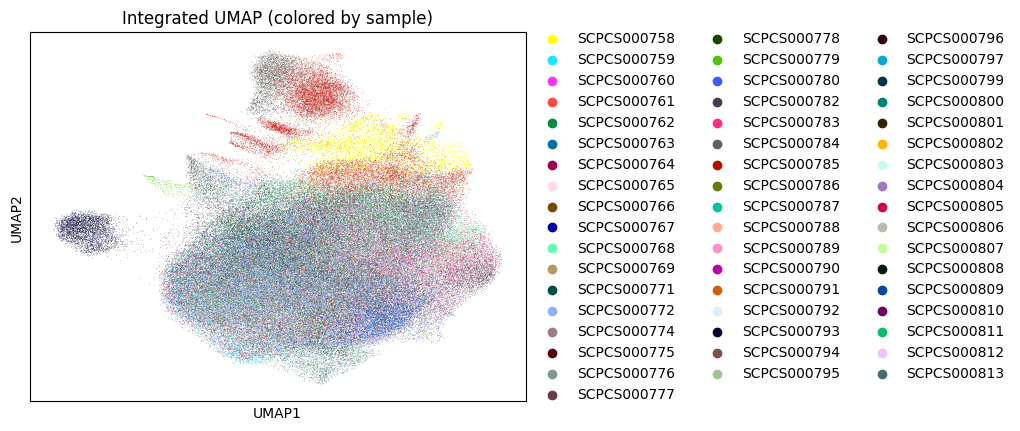

In [ ]:
# Check for batch correction by coloring by sample
sc.pl.umap(adata, color='sample_id', title='Integrated UMAP (colored by sample)')

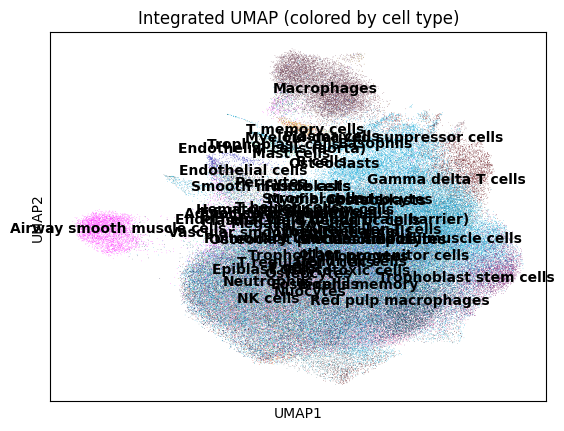

In [ ]:
# Check that biological structure is preserved by coloring by cell type
sc.pl.umap(adata, color='cellassign_celltype_annotation', title='Integrated UMAP (colored by cell type)', legend_loc='on data')

# Step 1: Initial Review and Preliminary Assessment

In [ ]:
# Option 2: If adata.var_names are Ensembl IDs and gene symbols are in adata.var['gene_symbol']
osteosarcoma_marker_symbols = ['COL1A1', 'CXCL12', 'MEPE', 'COL2A1']
# Get the var_names (e.g. Ensembl IDs) for these symbols
# Create a mapping from symbol to var_name if needed, or directly use boolean indexing
# This assumes 'gene_symbol' is a column in adata.var
osteosarcoma_markers_present = adata.var_names[adata.var['gene_symbol'].isin(osteosarcoma_marker_symbols)].tolist()

In [ ]:
# Assess expression of general osteosarcoma markers
sc.pl.umap(adata, color=osteosarcoma_markers_present, title=[f"{marker} Expression" for marker in osteosarcoma_marker_symbols if adata.var_names[adata.var['gene_symbol'] == marker][0] in osteosarcoma_markers_present])
sc.pl.dotplot(adata, osteosarcoma_markers_present, groupby='cellassign_celltype_annotation', title="Osteosarcoma Markers Expression by Cluster")

In [ ]:
# Assess expression of osteoblastic or chondroblastic subtype markers
osteoblastic_markers_symbols = ['RUNX2', 'COL3A1']
chondroblastic_markers_symbols = ['ACAN', 'COL2A1', 'SOX9']

osteoblastic_markers_present = adata.var_names[adata.var['gene_symbol'].isin(osteoblastic_markers_symbols)].tolist()
chondroblastic_markers_present = adata.var_names[adata.var['gene_symbol'].isin(chondroblastic_markers_symbols)].tolist()

if osteoblastic_markers_present:
    print("Assessing expression of osteoblastic markers")
    sc.pl.umap(adata, color=osteoblastic_markers_present, title=[f"{marker} Expression" for marker in osteoblastic_markers_symbols if adata.var_names[adata.var['gene_symbol'] == marker][0] in osteoblastic_markers_present])
    sc.pl.dotplot(adata, osteoblastic_markers_present, groupby='cellassign_celltype_annotation', title="Osteoblastic Markers Expression by Cluster")
if chondroblastic_markers_present:
    print("Assessing expression of chondroblastic markers")
    sc.pl.umap(adata, color=chondroblastic_markers_present, title=[f"{marker} Expression" for marker in chondroblastic_markers_symbols if adata.var_names[adata.var['gene_symbol'] == marker][0] in chondroblastic_markers_present])
    sc.pl.dotplot(adata, chondroblastic_markers_present, groupby='cellassign_celltype_annotation', title="Chondroblastic Markers Expression by Cluster")

# Step 2: Prepare Gene Order File for InferCNV

In [ ]:
external_gene_order_df = pd.read_csv('/content/drive/MyDrive/ALSF/gencode_v19_gene_pos.txt', sep='\t', header=None, names=['gene_symbol_external', 'chromosome', 'start', 'end'])

In [ ]:
external_gene_order_df.head()

,gene_symbol_external,chromosome,start,end
0,DDX11L1,chr1,11869,14412
1,WASH7P,chr1,14363,29806
2,MIR1302-11,chr1,29554,31109
3,FAM138A,chr1,34554,36081
4,OR4G4P,chr1,52473,54936


In [ ]:
gene_map_df = adata.var[['gene_symbol']].copy()

In [ ]:
gene_map_df = gene_map_df.reset_index()
gene_map_df.rename(columns={gene_map_df.columns[0]: 'Ensembl_ID'}, inplace=True)
gene_map_df.head()

,Ensembl_ID,gene_symbol
0,ENSG00000223972,DDX11L1
1,ENSG00000243485,MIR1302-2HG
2,ENSG00000284332,MIR1302-2
3,ENSG00000268020,OR4G4P
4,ENSG00000240361,OR4G11P


In [ ]:
# Clean the map: drop rows with missing gene symbols, drop duplicate symbols (keeping first Ensembl ID)
gene_map_df.dropna(subset=['gene_symbol'], inplace=True)
gene_map_df.drop_duplicates(subset=['gene_symbol'], keep='first', inplace=True) # Important for a clean merge

In [ ]:
gene_map_df.shape

(39162, 2)

In [ ]:
# Merge based on gene symbols from the external file and our map
merged_gene_order_df = pd.merge(
    external_gene_order_df,
    gene_map_df,
    left_on='gene_symbol_external',
    right_on='gene_symbol',
    how='inner' # Keep only genes present in both
)
print(f"Merged gene order data. Shape: {merged_gene_order_df.shape}")
print(merged_gene_order_df.head())

Merged gene order data. Shape: (30815, 6)
  gene_symbol_external chromosome  start    end       Ensembl_ID gene_symbol
0              DDX11L1       chr1  11869  14412  ENSG00000223972     DDX11L1
1               WASH7P       chr1  14363  29806  ENSG00000227232      WASH7P
2              FAM138A       chr1  34554  36081  ENSG00000237613     FAM138A
3               OR4G4P       chr1  52473  54936  ENSG00000268020      OR4G4P
4              OR4G11P       chr1  62948  63887  ENSG00000240361     OR4G11P


In [ ]:
final_gene_order_for_infercnpy_df = merged_gene_order_df[['Ensembl_ID', 'chromosome', 'start', 'end']].copy()
# Ensure Ensembl_IDs are unique (should be if gene_map_df was correctly prepared and Ensembl_IDs in adata are unique)
final_gene_order_for_infercnpy_df.drop_duplicates(subset=['Ensembl_ID'], keep='first', inplace=True)

In [ ]:
# Sort by chromosome and start position (critical for infercnpy)
# Handle chromosome strings like 'chrX', 'chrY', 'chrM' by converting 'chr' prefix to numerical for sorting
final_gene_order_for_infercnpy_df['chromosome_numerical'] = final_gene_order_for_infercnpy_df['chromosome'].astype(str).str.replace('chr', '')
# Replace X, Y, M with high numbers for sorting after numerical chromosomes
replace_map = {'X': 100, 'Y': 101, 'M': 102, 'MT': 102} # MT for mitochondrial
for k, v in replace_map.items():
    final_gene_order_for_infercnpy_df['chromosome_numerical'] = final_gene_order_for_infercnpy_df['chromosome_numerical'].replace(k, str(v))

In [ ]:
# Attempt to convert to numeric, coercing errors for any non-standard chromosome names
final_gene_order_for_infercnpy_df['chromosome_numerical'] = pd.to_numeric(final_gene_order_for_infercnpy_df['chromosome_numerical'], errors='coerce')
final_gene_order_for_infercnpy_df.dropna(subset=['chromosome_numerical'], inplace=True) # Drop if not convertible

final_gene_order_for_infercnpy_df = final_gene_order_for_infercnpy_df.sort_values(
    by=['chromosome_numerical', 'start']
).drop(columns=['chromosome_numerical'])

In [ ]:
# Save to a temporary file (tab-separated, no header, specific columns)
processed_gene_order_file_path = "/content/drive/MyDrive/ALSF/processed_gene_order_for_infercnpy.txt"
final_gene_order_for_infercnpy_df[['Ensembl_ID', 'chromosome', 'start', 'end']].to_csv(
    processed_gene_order_file_path, sep='\t', index=False, header=False
)
print(f"Processed gene order file saved to: {processed_gene_order_file_path}. Shape: {final_gene_order_for_infercnpy_df.shape}")
print(final_gene_order_for_infercnpy_df.head())

Processed gene order file saved to: /content/drive/MyDrive/ALSF/processed_gene_order_for_infercnpy.txt. Shape: (30815, 4)
        Ensembl_ID chromosome  start    end
0  ENSG00000223972       chr1  11869  14412
1  ENSG00000227232       chr1  14363  29806
2  ENSG00000237613       chr1  34554  36081
3  ENSG00000268020       chr1  52473  54936
4  ENSG00000240361       chr1  62948  63887


# Step 3: Define Reference Cell Types

In [ ]:
# prompt: create a list of reference cell types from a python list

reference_cell_types = [
    'Gamma delta T cells',
    'T cytotoxic cells',
    'T cells',
    'T regulatory cells',
    'Monocytes',
    'Macrophages',
    'Red pulp macrophages',
    'Dendritic cells',
    'Neutrophils',
    'NK cells',
    'B cells memory',
    'Nuocytes',
    'Endothelial cells'
]

print("Reference cell types list created:")
reference_cell_types

Reference cell types list created:


['Gamma delta T cells',
 'T cytotoxic cells',
 'T cells',
 'T regulatory cells',
 'Monocytes',
 'Macrophages',
 'Red pulp macrophages',
 'Dendritic cells',
 'Neutrophils',
 'NK cells',
 'B cells memory',
 'Nuocytes',
 'Endothelial cells']

In [ ]:
# reference_cell_types = adata.obs['cellassign_celltype_annotation'].unique()

In [ ]:
adata.obs['cnv_ref_group'] = adata.obs['cellassign_celltype_annotation'].astype(str)
available_ref_types = [ct for ct in reference_cell_types if ct in adata.obs['cnv_ref_group'].unique()]
print(f"Using the following cell types as reference: {available_ref_types}")

Using the following cell types as reference: ['Gamma delta T cells', 'T cytotoxic cells', 'T cells', 'T regulatory cells', 'Monocytes', 'Macrophages', 'Red pulp macrophages', 'Dendritic cells', 'Neutrophils', 'NK cells', 'B cells memory', 'Nuocytes', 'Endothelial cells']


# Step 4: Run Infercnpy

In [ ]:
# Subset AnnData to genes that are present in our final_gene_order_for_infercnpy_df
# These are the genes for which we have genomic coordinates.
common_genes_with_coords = final_gene_order_for_infercnpy_df['Ensembl_ID'].unique().tolist()
common_genes_in_adata = [gene for gene in adata.var_names if gene in common_genes_with_coords]

In [ ]:
adata_subset_for_cnv = adata[:, common_genes_in_adata].copy()
print(f"adata_subset_for_cnv created with {adata_subset_for_cnv.n_vars} genes and {adata_subset_for_cnv.n_obs} cells.")

adata_subset_for_cnv created with 30815 genes and 195167 cells.


In [ ]:
adata_subset_for_cnv.var_names

Index(['ENSG00000223972', 'ENSG00000284332', 'ENSG00000268020',
       'ENSG00000240361', 'ENSG00000186092', 'ENSG00000233750',
       'ENSG00000269732', 'ENSG00000233653', 'ENSG00000225972',
       'ENSG00000225630',
       ...
       'ENSG00000235412', 'ENSG00000183795', 'ENSG00000234583',
       'ENSG00000129845', 'ENSG00000229302', 'ENSG00000226362',
       'ENSG00000226092', 'ENSG00000225491', 'ENSG00000185894',
       'ENSG00000228296'],
      dtype='object', length=30815)

In [ ]:
# Add chromosome, start, and end information to adata_subset_for_cnv.var
# The gene order DataFrame needs to be indexed by 'Ensembl_ID' to align with adata_subset_for_cnv.var_names
gene_order_info_to_add = final_gene_order_for_infercnpy_df.set_index('Ensembl_ID')

In [ ]:
# Keep only the coordinate columns needed, ensure they are present
coordinate_cols = ['chromosome', 'start', 'end']
for col in coordinate_cols:
    if col not in gene_order_info_to_add.columns:
        raise ValueError(f"Column '{col}' is missing from the gene order information DataFrame.")

In [ ]:
# Join the coordinate information. This aligns based on the index (Ensembl_ID).
adata_subset_for_cnv.var = adata_subset_for_cnv.var.join(gene_order_info_to_add[coordinate_cols])

In [ ]:
# Verify that the columns were added and populated
print("Verifying .var columns after adding coordinates:")
print(adata_subset_for_cnv.var.head())
if adata_subset_for_cnv.var['chromosome'].isnull().any() or \
   adata_subset_for_cnv.var['start'].isnull().any() or \
   adata_subset_for_cnv.var['end'].isnull().any():
    print("Warning: Some genes in adata_subset_for_cnv.var have missing chromosome/start/end information after join.")
    print(adata_subset_for_cnv.var[adata_subset_for_cnv.var['chromosome'].isnull()].head())
    # Consider dropping these genes or investigating the merge if this happens unexpectedly
    # adata_subset_for_cnv = adata_subset_for_cnv[:, adata_subset_for_cnv.var['chromosome'].notnull()].copy()
    # print(f"Subsetted further to {adata_subset_for_cnv.n_vars} genes with complete coordinate info.")


Verifying .var columns after adding coordinates:
                        gene_ids gene_symbol  SCPCL001120.mean  \
ENSG00000223972  ENSG00000223972     DDX11L1           0.00061   
ENSG00000284332  ENSG00000284332   MIR1302-2           0.00000   
ENSG00000268020  ENSG00000268020      OR4G4P           0.00000   
ENSG00000240361  ENSG00000240361     OR4G11P           0.00000   
ENSG00000186092  ENSG00000186092       OR4F5           0.00000   

                 SCPCL001120.detected  SCPCL001121.mean  SCPCL001121.detected  \
ENSG00000223972                 0.061               0.0                   0.0   
ENSG00000284332                 0.000               0.0                   0.0   
ENSG00000268020                 0.000               0.0                   0.0   
ENSG00000240361                 0.000               0.0                   0.0   
ENSG00000186092                 0.000               0.0                   0.0   

                 SCPCL001122.mean  SCPCL001122.detected  SCPCL00112

In [ ]:
# Ensure the cnv_ref_group column is also in the subset if not already copied over by adata[:, common_genes_in_adata].copy()
# .copy() on a view should bring .obs along.
if 'cnv_ref_group' not in adata_subset_for_cnv.obs.columns and 'cnv_ref_group' in adata.obs.columns:
    adata_subset_for_cnv.obs['cnv_ref_group'] = adata.obs.loc[adata_subset_for_cnv.obs_names, 'cnv_ref_group']

available_ref_types = [ct for ct in reference_cell_types if ct in adata_subset_for_cnv.obs['cnv_ref_group'].unique()]
print(f"Using the following cell types as reference: {available_ref_types}")

Using the following cell types as reference: ['Gamma delta T cells', 'T cytotoxic cells', 'T cells', 'T regulatory cells', 'Monocytes', 'Macrophages', 'Red pulp macrophages', 'Dendritic cells', 'Neutrophils', 'NK cells', 'B cells memory', 'Nuocytes', 'Endothelial cells']


In [ ]:
cnv.tl.infercnv(
        adata_subset_for_cnv,
        reference_key='cnv_ref_group',
        reference_cat=available_ref_types,
        # reference=None, # Default
        lfc_clip=3, # Default, can be adjusted
        window_size=50, # Default, can be adjusted
        step=5, # Default, can be adjusted
        dynamic_threshold=1.5, # Default, can be adjusted
        exclude_chromosomes=('chrX', 'chrY', 'chrM', 'chrMT'), # Default, adjust if needed e.g. ('chrX', 'chrY', 'chrM', 'chrMT')
        # chunksize=5000, # Default
        # n_jobs=None, # Default (all cores)
        inplace=True, # Default
        # layer=None, # Default (uses .X)
        key_added='cnv', # Default, stores in .obsm[f'X_{key_added}'] and .uns[key_added]
        # calculate_gene_values=False # Default
)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
# Transfer results back to the main adata object
cnv_key_obsm = f"X_{'cnv'}" # Default key_added is 'cnv'
cnv_key_uns = 'cnv'

In [ ]:
adata

AnnData object with n_obs × n_vars = 195167 × 60319
    obs: 'barcodes', 'sum', 'detected', 'total', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'miQC_pass', 'prob_compromised', 'scpca_filter', 'additional_modalities', 'singler_celltype_annotation', 'singler_celltype_ontology', 'cellassign_celltype_annotation', 'cellassign_celltype_ontology', 'cellassign_max_prediction', 'consensus_celltype_annotation', 'consensus_celltype_ontology', 'library_id', 'cell_id', 'sample_id', 'scpca_project_id', 'submitter_id', 'participant_id', 'submitter', 'age', 'age_timing', 'sex', 'diagnosis', 'subdiagnosis', 'tissue_location', 'disease_timing', 'organism', 'is_xenograft', 'is_cell_line', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'tech_version', 'assay_ontology_term_id', 'suspension_type', '_scvi_batch', '_scvi_labels', 'cnv_ref_group'
 

In [ ]:
# Save the adata to a new h5ad file

output_adata_file = '/content/drive/MyDrive/ALSF/SCPCP000023/SCPCP000023_cnv_subset_rna.h5ad'
adata_subset_for_cnv.write_h5ad(output_adata_file)
print(f"Processed adata saved to: {output_adata_file}")

Processed adata saved to: /content/drive/MyDrive/ALSF/SCPCP000023/SCPCP000023_cnv_subset_rna.h5ad


In [ ]:
adata_subset_for_cnv

AnnData object with n_obs × n_vars = 195167 × 30815
    obs: 'barcodes', 'sum', 'detected', 'total', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'miQC_pass', 'prob_compromised', 'scpca_filter', 'additional_modalities', 'singler_celltype_annotation', 'singler_celltype_ontology', 'cellassign_celltype_annotation', 'cellassign_celltype_ontology', 'cellassign_max_prediction', 'consensus_celltype_annotation', 'consensus_celltype_ontology', 'library_id', 'cell_id', 'sample_id', 'scpca_project_id', 'submitter_id', 'participant_id', 'submitter', 'age', 'age_timing', 'sex', 'diagnosis', 'subdiagnosis', 'tissue_location', 'disease_timing', 'organism', 'is_xenograft', 'is_cell_line', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'tech_version', 'assay_ontology_term_id', 'suspension_type', '_scvi_batch', '_scvi_labels', 'cnv_ref_group'
 